## Setup and Cleaning

In [108]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.naive_bayes import MultinomialNB

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)


In [2]:
battles = pd.read_csv('battles.csv')
character_deaths = pd.read_csv('character-deaths.csv')
character_predictions = pd.read_csv('character-predictions.csv')

In [3]:
# start with character_predictions as main df
df = character_predictions

# add calculated cols: num_books, culture, 
df.loc[:, "num_books"] = df[[x for x in df.columns if x.startswith("book")]].sum(axis = 1)

cult = {
    'Summer Islands': ['summer islands', 'summer islander', 'summer isles'],
    'Ghiscari': ['ghiscari', 'ghiscaricari',  'ghis'],
    'Asshai': ["asshai'i", 'asshai'],
    'Lysene': ['lysene', 'lyseni'],
    'Andal': ['andal', 'andals'],
    'Braavosi': ['braavosi', 'braavos'],
    'Dornish': ['dornishmen', 'dorne', 'dornish'],
    'Myrish': ['myr', 'myrish', 'myrmen'],
    'Westermen': ['westermen', 'westerman', 'westerlands'],
    'Westerosi': ['westeros', 'westerosi'],
    'Stormlander': ['stormlands', 'stormlander'],
    'Norvoshi': ['norvos', 'norvoshi'],
    'Northmen': ['the north', 'northmen'],
    'Free Folk': ['wildling', 'first men', 'free folk'],
    'Qartheen': ['qartheen', 'qarth'],
    'Reach': ['the reach', 'reach', 'reachmen'],
}

def get_cult(value):
    value = value.lower()
    v = [k for (k, v) in cult.items() if value in v]
    return v[0] if len(v) > 0 else value.title()

df.loc[:, "culture"] = [get_cult(x) for x in df.culture.fillna("")]

# convert 'house' and 'name' to string
df['house'] = df['house'].astype(str)
df['name'] = df['name'].astype(str)

# add col to see if character's name also appears in the house name
name_check=[]

for i in range(len(df)):
    name_set = set(df.ix[i,'name'].split(' '))
    house_set = set(df.ix[i,'house'].split(' '))
    name_check.append(int(bool(name_set&house_set)))
    
df['name_in_house'] = name_check

In [4]:
# get rid of previous prediction information from source data; we're going to make our own predictions!
df.drop(['S.No','actual','pred','alive','plod'],axis=1,inplace=True)

In [ ]:
# transform culture into dummy variables and append to dataframe
culture_dummies = pd.get_dummies(df.culture).iloc[:,1:]
df = pd.concat([df,culture_dummies],axis=1)

In [48]:
# add age groups

df['is_old'] = df['age'].apply(lambda x: 1 if x>70 else 0)
df['is_young'] = df['age'].apply(lambda x: 1 if x<18 else 0)
df['is_middle_aged'] = df['age'].apply(lambda x: 1 if x>=18 and x<=70 else 0)

## Data Exploration

In [144]:
def plot(cat):
    df.groupby(cat).isAlive.mean().plot(kind='bar')
    plt.ylabel('Percent Alive')
    plt.ylim([0.0, 1.0])
    plt.show()

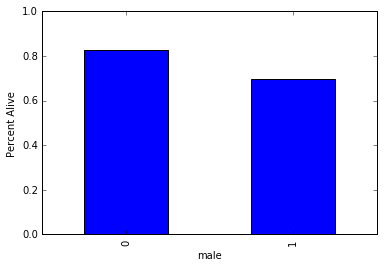

In [145]:
plot('male')

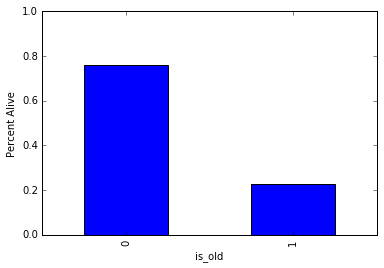

In [152]:
plot('is_old')

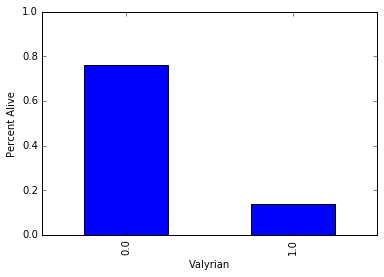

In [154]:
plot('Valyrian')

In [160]:
# popularity: https://docs.google.com/spreadsheets/d/1WQlsF_agiphO1TUYb0W8cLwd-OL4RYvTtFDq08mV0QI/edit?usp=sharing

## Null Accuracy Rate

In [76]:
# compute null accuracy rate
na_rate = y.mean()
print 'null accuracy rate: %s' %na_rate

null accuracy rate: 0.745632065776


## Train/Test/Split

In [99]:
# train/test/split used for models

feature_cols = ['male','book1','book2','book3','book4','book5','isMarried','isNoble','popularity','name_in_house',\
                'boolDeadRelations','is_old','is_young','is_middle_aged']+list(culture_dummies.columns.values)
X = df[feature_cols]
y = df.isAlive

X_train, X_test, y_train, y_test = train_test_split(X, y)

## Metrics and Confusion Matrix

In [115]:
# define output

# confusion matrix
def plot_confusion_matrix(cm, order, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(order))
    plt.xticks(tick_marks, order, rotation=0)
    plt.yticks(tick_marks, order)
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def roc_auc():
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.show()
    print 'AUC: %s' %metrics.roc_auc_score(y_test, probs)
    
def SCORE(model):
    print 'accuracy: %s' %metrics.accuracy_score(y_test, preds)
    print 'compared to null accuracy rate of: %s' %y_test.mean()
    cm = metrics.confusion_matrix(y_test, preds)
    plt.figure()
    plot_confusion_matrix(cm,['dead','alive'])
    
    sensitivity = 1.*cm[1,1]/sum(cm[1,:])
    print 'sensitivity (if alive, chance we predicted correctly): ' + str(sensitivity)

    specificity = 1.*cm[0,0]/sum(cm[0,:])
    print 'specificity (if dead, chance we predicted correctly): ' + str(specificity)
    roc_auc()

    cv_score = cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean()
    print 'cross_val_score: %s' %cv_score

    
'''
top left: predicted dead, actually died
bottom left: predicted dead, actually alive
top right: predicted alive, actually dead
bottom right: predicted alive, actually alive
'''


'\ntop left: predicted dead, actually died\nbottom left: predicted dead, actually alive\ntop right: predicted alive, actually dead\nbottom right: predicted alive, actually alive\n'

## Model 1: Logistic Regression
TODO: Normalize column values, cross validation, tune model, ROC/AUC

accuracy: 0.804928131417
compared to null accuracy rate of: 0.749486652977


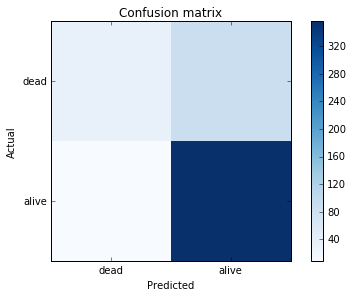

sensitivity (if alive, chance we predicted correctly): 0.975342465753
specificity (if dead, chance we predicted correctly): 0.295081967213


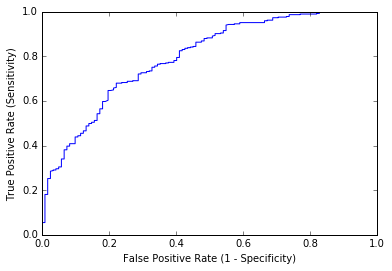

AUC: 0.795744441949
cross_val_score: 0.757565480609


In [116]:
# Model 1: Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train,y_train)
preds = logreg.predict(X_test)
probs = logreg.predict_proba(X_test)[:, 1]
SCORE(logreg)



## Model 2: Decision Tree / Random Forest

## Model 3: Bayesian

accuracy: 0.796714579055
compared to null accuracy rate of: 0.749486652977


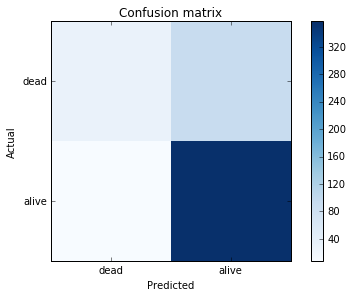

sensitivity (if alive, chance we predicted correctly): 0.978082191781
specificity (if dead, chance we predicted correctly): 0.254098360656


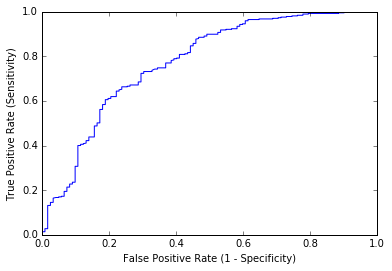

AUC: 0.773781720189
cross_val_score: 0.724628837496


In [117]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
preds = nb.predict(X_test)
probs = nb.predict_proba(X_test)[:, 1]
SCORE(nb)

## Which Characters that Are Still Alive Have Highest Chance of Death? (LogReg)

In [134]:
df['likelihood_of_death'] = 1 - logreg.predict_proba(X)[:, 1]
df[df.isAlive==1].sort_values(by='prediction')[['name','likelihood_of_death']].head(12)

,name,likelihood_of_death
1677,Daenerys Targaryen,0.826877
1835,Tysha,0.801951
1,Walder Frey,0.780956
909,Ardrian Celtigar,0.779719
283,Aegon Targaryen (son of Baelon),0.725444
5,Tommen Baratheon,0.719526
172,Stannis Baratheon,0.719526
1741,Jaime Lannister,0.704333
387,Bryen,0.690051
328,Ayrmidon,0.671972


## OLD CODE NOT IN USE

In [ ]:
'''
def died(df):
    if np.isnan(df['Death Year']) and np.isnan(df['Book of Death']) and np.isnan(df['Death Chapter']):
        return False
    else:
        return True

character_deaths['died'] = character_deaths.apply(died,axis=1)
'''